In [5]:
#conda install --channel conda-forge carterbox-torch-radon
#!pip install matplotlib
#!pip install opencv-python
#!sudo apt update && apt install -y libsm6 libxext6
#!sudo apt-get install -y libxrender-dev
#!pip install pytorch-msssim
#!nvidia-smi

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from modules.operators.RadonTorch import RadonTorch
from modules.operators.TotalVariationTorch import TotalVariationTorch
import numpy as np
from modules.algorithm.ConjugateGradient import ConjugateGradient as CG
from modules.models.MetaInvNet import *
from modules.models.Unet import *
import torch
import torch_radon as tr
import os
import s3fs
from math import sqrt


device = 'cuda'

In [2]:
# connection db

S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET_X_TRUE_TEST = "antoinedp/x_clem"
x_true_test_filenames = fs.ls(BUCKET_X_TRUE_TEST)[1:]

In [3]:
# load ground truth

def import_data(file_paths):
    data = []
    for file_path in file_paths:
        with fs.open(file_path, mode="rb") as file_in:
            data.append(np.load(file_in, encoding="bytes"))
    return data
    
x_true_test = import_data(x_true_test_filenames)

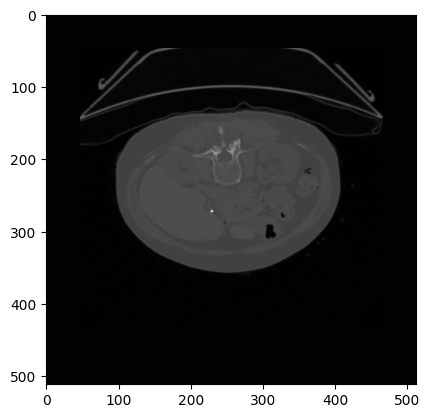

In [4]:
plt.imshow(x_true_test[55], cmap="gray")
plt.show()

In [5]:
# set projector

angles = np.linspace(0, np.pi, 52, endpoint=False)
volume = tr.Volume2D()
volume.set_size(height=512, width=512)
radon = RadonTorch(512, angles, volume)


# Pre processing for MetaInvNet

In [6]:
x_true_test_tensor = torch.from_numpy(np.array(x_true_test)).to(dtype=torch.float32).to(device).unsqueeze(1)


## Noise

In [7]:
# some utils transformations
import torchvision.transforms as transforms

normalize = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())) 
])

# add poisson noise to to sinogram:
I = 3e5 

x_true_test_tensor_metainvnet_3e5 = normalize(x_true_test_tensor)
true_sino_test_tensor_metainvnet_3e5 = radon.transform(x_true_test_tensor_metainvnet_3e5)
sino_test_tensor_metainvnet_3e5 = true_sino_test_tensor_metainvnet_3e5.max() * torch.log(I/torch.poisson(I*torch.exp(-true_sino_test_tensor_metainvnet_3e5/true_sino_test_tensor_metainvnet_3e5.max())))
noisy_x_fbp_test_tensor_metainvnet_3e5 = radon.transposed_transform(radon.radon.filter_sinogram(sino_test_tensor_metainvnet_3e5))

# free memory
with torch.no_grad():
    del true_sino_test_tensor_metainvnet_3e5
    torch.cuda.empty_cache()

x_fbp_test_tensor_metainvnet_3e5 = normalize(noisy_x_fbp_test_tensor_metainvnet_3e5)

# free memory
with torch.no_grad():
    del noisy_x_fbp_test_tensor_metainvnet_3e5
    torch.cuda.empty_cache()

/opt/mamba/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/mamba/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


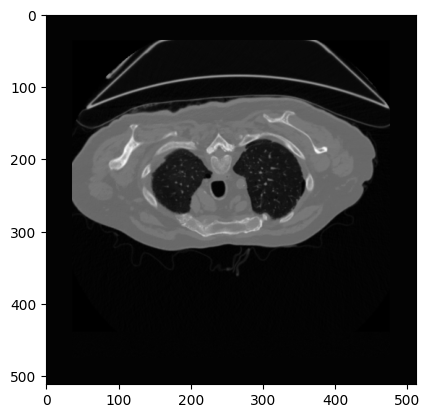

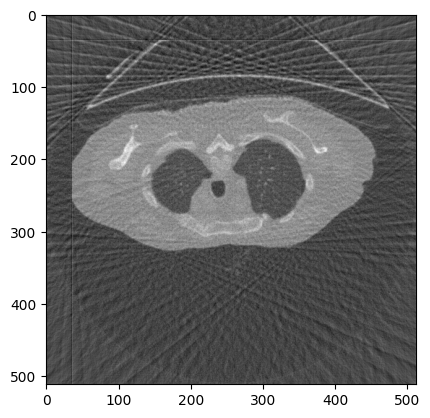

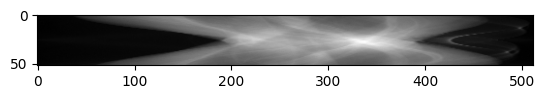

In [8]:
from matplotlib import pyplot as plt
plt.imshow(x_true_test_tensor_metainvnet_3e5[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(x_fbp_test_tensor_metainvnet_3e5[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(sino_test_tensor_metainvnet_3e5[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()

## Non - Noise

In [9]:
# some utils transformations
import torchvision.transforms as transforms

normalize = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())) 
])

x_true_test_tensor_metainvnet = normalize(x_true_test_tensor)
sino_test_tensor_metainvnet = radon.transform(x_true_test_tensor_metainvnet)
x_fbp_test_tensor_metainvnet = radon.transposed_transform(radon.radon.filter_sinogram(sino_test_tensor_metainvnet))

x_fbp_test_tensor_metainvnet = normalize(x_fbp_test_tensor_metainvnet)


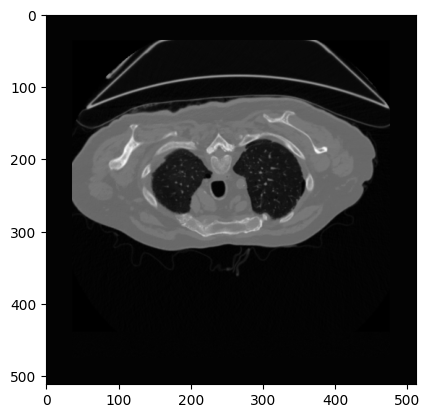

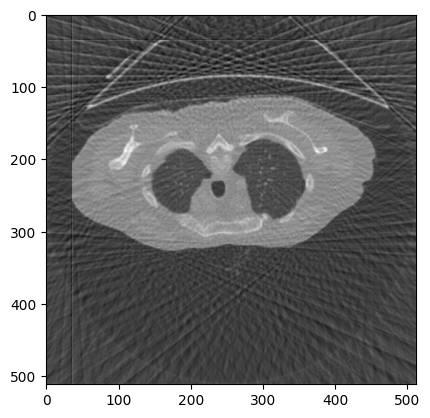

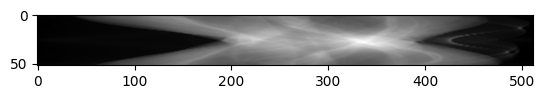

In [10]:
from matplotlib import pyplot as plt
plt.imshow(x_true_test_tensor_metainvnet[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(x_fbp_test_tensor_metainvnet[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(sino_test_tensor_metainvnet[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()

# Pre processing for Unet

## Non - Noise

In [11]:
x_true_test_tensor_unet = x_true_test_tensor
sino_test_tensor_unet = radon.transform(x_true_test_tensor)
filtered_noisy_sino_test_tensor_unet = radon.radon.filter_sinogram(sino_test_tensor_unet)
x_fbp_test_tensor_unet = radon.transposed_transform(filtered_noisy_sino_test_tensor_unet)

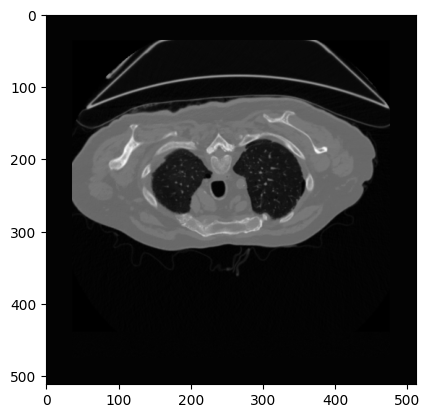

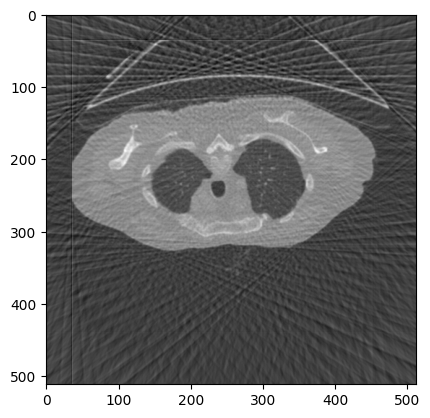

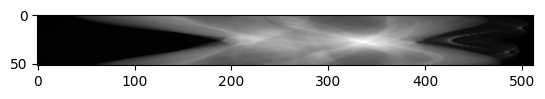

In [12]:
from matplotlib import pyplot as plt
plt.imshow(x_true_test_tensor_unet[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(x_fbp_test_tensor_unet[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(sino_test_tensor_unet[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()

## Noise

In [13]:
x_true_test_tensor_unet_3e5 = x_true_test_tensor

# add poisson noise to to sinogram:
I = 3e5 

sino_test_tensor_unet_3e5 = radon.transform(x_true_test_tensor)

y_test_unet_3e5 = torch.poisson(I*torch.exp(-sino_test_tensor_unet_3e5))
noisy_sino_test_tensor_unet_3e5 = torch.log(I/y_test_unet_3e5)
filtered_noisy_sino_test_tensor_unet_3e5=radon.radon.filter_sinogram(noisy_sino_test_tensor_unet_3e5)
x_fbp_test_tensor_unet_3e5 = radon.transposed_transform(filtered_noisy_sino_test_tensor_unet_3e5)


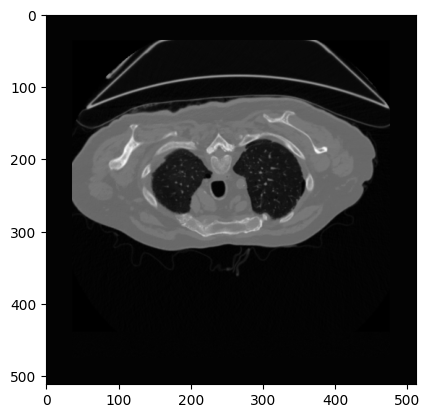

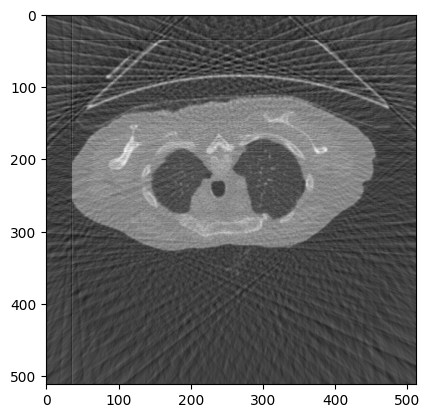

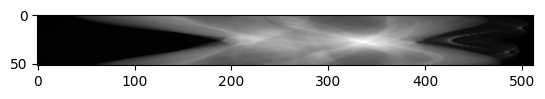

In [14]:
from matplotlib import pyplot as plt
plt.imshow(x_true_test_tensor_unet_3e5[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(x_fbp_test_tensor_unet_3e5[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()
plt.imshow(sino_test_tensor_unet_3e5[95].to('cpu').squeeze(0).squeeze(0).numpy(), cmap="gray")
plt.show()

In [15]:
# Custom Dataset and Dataloaders

In [16]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class CustomDatasetMetaInvNet(Dataset):
    def __init__(self, sino, x_fbp, x_true):
        super(CustomDatasetMetaInvNet, self).__init__()
        self.sino = sino
        self.x_fbp = x_fbp
        self.x_true = x_true

    def __getitem__(self, index):
        return self.sino[index,], self.x_fbp[index,], self.x_true[index,]

    def __len__(self):
        return len(self.sino)


mean_x_fbp_train_3e5 = 0.0047
std_x_fbp_train_3e5 = 0.0080
mean_x_true_train_3e5 = 0.0044
std_x_true_train_3e5 = 0.0076

normalize_x_fbp_3e5 = transforms.Compose([
    transforms.Normalize(mean=[mean_x_fbp_train_3e5], std=[std_x_fbp_train_3e5])
])

normalize_x_true_3e5 = transforms.Compose([
    transforms.Normalize(mean=[mean_x_true_train_3e5], std=[std_x_true_train_3e5])
])

mean_x_fbp_train = 0.0047
std_x_fbp_train = 0.0078
mean_x_true_train = 0.0044
std_x_true_train = 0.0076


normalize_x_fbp = transforms.Compose([
    transforms.Normalize(mean=[mean_x_fbp_train], std=[std_x_fbp_train])
])

normalize_x_true = transforms.Compose([
    transforms.Normalize(mean=[mean_x_true_train], std=[std_x_true_train])
])

class CustomDatasetUnet(Dataset):
    
    def __init__(self, X, y, transform, target_transform):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        x = self.transform(self.X[idx])
        y = self.target_transform(self.y[idx])
                    
        return x, y



dataloader_test_unet = DataLoader(CustomDatasetUnet(x_fbp_test_tensor_unet, x_true_test_tensor_unet, normalize_x_fbp, normalize_x_true), batch_size=1, shuffle=False)
dataloader_test_unet_3e5 = DataLoader(CustomDatasetUnet(x_fbp_test_tensor_unet_3e5, x_true_test_tensor_unet_3e5, normalize_x_fbp_3e5, normalize_x_true_3e5), batch_size=1, shuffle=False)

dataloader_test_metainvnet = DataLoader(CustomDatasetMetaInvNet(sino_test_tensor_metainvnet, x_fbp_test_tensor_metainvnet, x_true_test_tensor_metainvnet), batch_size=1, shuffle=False)
dataloader_test_metainvnet_3e5 = DataLoader(CustomDatasetMetaInvNet(sino_test_tensor_metainvnet_3e5, x_fbp_test_tensor_metainvnet_3e5, x_true_test_tensor_metainvnet_3e5), batch_size=1, shuffle=False)



# Import model

In [17]:
modelUnetL1 = UNet().to(device)
modelUnetL2 = UNet().to(device)
modelUnetL1noisy = UNet().to(device)
modelUnetL2noisy = UNet().to(device)

# load model
with fs.open("antoinedp/weights/unet_l1_noisy_3e5.pth", mode="rb") as file_in:
    checkpoint_unet_l1_noisy_3e5 = torch.load(file_in)

with fs.open("antoinedp/weights/unet_l2_noisy_3e5.pth", mode="rb") as file_in:
    checkpoint_unet_l2_noisy_3e5 = torch.load(file_in)

with fs.open("antoinedp/weights/unet_l1.pth", mode="rb") as file_in:
    checkpoint_unet_l1 = torch.load(file_in)

with fs.open("antoinedp/weights/unet_l2.pth", mode="rb") as file_in:
    checkpoint_unet_l2 = torch.load(file_in)


modelUnetL1.load_state_dict(checkpoint_unet_l1['model_state_dict'])
modelUnetL2.load_state_dict(checkpoint_unet_l2['model_state_dict'])
modelUnetL1noisy.load_state_dict(checkpoint_unet_l1_noisy_3e5['model_state_dict'])
modelUnetL2noisy.load_state_dict(checkpoint_unet_l2_noisy_3e5['model_state_dict'])

modelUnetL1.eval()
modelUnetL2.eval()
modelUnetL1noisy.eval()
modelUnetL2noisy.eval()


UNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (ds1): DownSamplingBlock(
    (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
  )
  (ds2): DownSamplingBlock(
    (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv

In [19]:
tv = TotalVariationTorch()

#modelMetaInvL1 = MetaInvNetL(10, radon, tv, 0.01, 15).to(device)
modelMetaInvL2 = MetaInvNetL(10, radon, tv, 0.01, 15).to(device)
modelMetaInvL1noisy = MetaInvNetL(10, radon, tv, 0.005, 200).to(device)
modelMetaInvL2noisy = MetaInvNetL(10, radon, tv, 0.005, 200).to(device)
def loss_fun():
    pass

def metainvnet_loss_l1():
    pass

def metainvnet_loss_l2():
    pass



#with fs.open("antoinedp/weights/metainvnet_tv_0_01_15_l1_loss_20ep.pth", mode="rb") as file_in:
#    metainvnet_tv_0_01_15_l1_loss_20ep = torch.load(file_in)

with fs.open("antoinedp/weights/metainvnet_tv_0_01_15_l2_loss_18ep.pth", mode="rb") as file_in:
    metainvnet_tv_0_01_15_l2_loss_18ep = torch.load(file_in)

with fs.open("antoinedp/weights/metainvnet_3e5_tv_0_005_200_l1_loss_20ep.pth", mode="rb") as file_in:
    checkpoint_metainvnet_3e5_tv_0_005_200_l1_loss_20ep = torch.load(file_in)

with fs.open("antoinedp/weights/metainvnet_3e5_tv_0_005_200_l2_loss_20ep.pth", mode="rb") as file_in:
    checkpoint_metainvnet_3e5_tv_0_005_200_l2_loss_20ep = torch.load(file_in)


#modelMetaInvL1.load_state_dict(metainvnet_tv_0_01_15_l1_loss_20ep['model_state_dict'])
modelMetaInvL2.load_state_dict(metainvnet_tv_0_01_15_l2_loss_18ep['model_state_dict'])
modelMetaInvL1noisy.load_state_dict(checkpoint_metainvnet_3e5_tv_0_005_200_l1_loss_20ep['model_state_dict'])
modelMetaInvL2noisy.load_state_dict(checkpoint_metainvnet_3e5_tv_0_005_200_l2_loss_20ep['model_state_dict'])


#modelMetaInvL1.eval()
modelMetaInvL2.eval()
modelMetaInvL1noisy.eval()
modelMetaInvL2noisy.eval()

MetaInvNetL(
  (unrolled_net): ModuleList(
    (0-10): 11 x MetaInvLOneIter(
      (CGInitDnCNN): DnCNN(
        (dncnn): Sequential(
          (0): Conv2dPReLU(
            (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (prelu): PReLU(num_parameters=8)
          )
          (1): Conv2dPReLU(
            (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (prelu): PReLU(num_parameters=8)
          )
          (2): Conv2dPReLU(
            (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (prelu): PReLU(num_parameters=8)
          )
          (3): Conv2dPReLU(
            (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (prelu): PReLU(num_parameters=8)
          )
          (4): Conv2dPReLU(
            (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (prelu): PReLU(num_parameters=8)
          )
          (5): Conv2d

In [20]:
from pytorch_msssim import SSIM, MS_SSIM


def ssim(pred, y):
    data_range = torch.max(torch.tensor([torch.max(pred) - torch.min(pred), torch.max(y) - torch.min(y)]))
    ssim = SSIM(win_size=11, win_sigma=1.5, data_range=data_range, size_average=True, channel=1)
    return ssim(pred, y).item()


def psnr(original, reconstructed):
    # normalizing to have pixels between 0 and 1 to compute the peak signal to noise ratio
    noriginal = (original - torch.min(original)) / (torch.max(original) - torch.min(original))
    nreconstructed = (reconstructed - torch.min(reconstructed)) / (torch.max(reconstructed) - torch.min(reconstructed))

    # compute Mean Squared Error (MSE)
    mse = torch.mean((noriginal - nreconstructed) ** 2)

    # compute PSNR in decibels
    if mse == 0:
        return float('inf')  # PSNR is infinite if the images are identical
    else:
        psnr_value = 10 * torch.log10((1 ** 2) / mse)  # 1 being the max pixel value / range of pixel values
        return psnr_value.item()  # Convert tensor to float value



In [23]:
import torch
def compute_ssim_psnr(model, model_type, dataloader):
    ssim_list = []
    psnr_list = []
    if model_type == "unet":
        for x_fbp, x_true in dataloader:
            pred = model(x_fbp)
            
            ssim_list.append(ssim(pred, x_true))

            psnr_list.append(psnr(pred, x_true))

    if model_type == "metainvnet":
         for sino, x_fbp, x_true in dataloader:
            pred = model(sino, x_fbp)
            ssim_list.append(ssim(pred[len(pred) - 1], x_true))
            psnr_list.append(psnr(pred[len(pred) - 1], x_true))

    return np.mean(ssim_list), np.mean(psnr_list), ssim_list, psnr_list
    

metrics_unet_l1 = compute_ssim_psnr(modelUnetL1, "unet", dataloader_test_unet)
metrics_unet_l2 = compute_ssim_psnr(modelUnetL2 ,"unet", dataloader_test_unet)
metrics_unet_l1_noisy = compute_ssim_psnr(modelUnetL1noisy ,"unet", dataloader_test_unet_3e5)
metrics_unet_l2_noisy = compute_ssim_psnr(modelUnetL2noisy ,"unet", dataloader_test_unet_3e5)


#metrics_metainvnet_l1 = compute_ssim_psnr(modelMetaInvL1 ,"metainvnet", dataloader_test_metainvnet)
metrics_metainvnet_l2 = compute_ssim_psnr(modelMetaInvL2 ,"metainvnet", dataloader_test_metainvnet)
metrics_metainvnet_l1_noisy = compute_ssim_psnr(modelMetaInvL1noisy ,"metainvnet", dataloader_test_metainvnet_3e5)
metrics_metainvnet_l2_noisy = compute_ssim_psnr(modelMetaInvL2noisy ,"metainvnet", dataloader_test_metainvnet_3e5)

print(f"metrics_unet_l1 : ssim = {metrics_unet_l1[0]}, psnr = {metrics_unet_l1[1]}")
print(f"metrics_unet_l2 : ssim = {metrics_unet_l2[0]}, psnr = {metrics_unet_l2[1]}")
#print(f"metrics_metainvnet_l1 : ssim = {metrics_metainvnet_l1[0]}, psnr = {metrics_metainvnet_l1[1]}")
print(f"metrics_metainvnet_l2 : ssim = {metrics_metainvnet_l2[0]}, psnr = {metrics_metainvnet_l2[1]}")

print('------------------')

print(f"metrics_unet_l1_noisy : ssim = {metrics_unet_l1_noisy[0]}, psnr = {metrics_unet_l1_noisy[1]}")
print(f"metrics_unet_l2_noisy : ssim = {metrics_unet_l2_noisy[0]}, psnr = {metrics_unet_l2_noisy[1]}")

print(f"metrics_metainvnet_l1_noisy : ssim = {metrics_metainvnet_l1_noisy[0]}, psnr = {metrics_metainvnet_l1_noisy[1]}")
print(f"metrics_metainvnet_l2_noisy : ssim = {metrics_metainvnet_l2_noisy[0]}, psnr = {metrics_metainvnet_l2_noisy[1]}")




metrics_unet_l1 : ssim = 0.9777439945936203, psnr = 38.47024444580078
metrics_unet_l2 : ssim = 0.978549964427948, psnr = 40.587331771850586
metrics_metainvnet_l2 : ssim = 0.9841048157215119, psnr = 36.35221839904785
------------------
metrics_unet_l1_noisy : ssim = 0.9743238323926926, psnr = 37.09454370498657
metrics_unet_l2_noisy : ssim = 0.9747992122173309, psnr = 38.573017597198486
metrics_metainvnet_l1_noisy : ssim = 0.9656825023889541, psnr = 33.29211116790771
metrics_metainvnet_l2_noisy : ssim = 0.9680977606773377, psnr = 34.152000484466555


# Some prediction

In [24]:
def compute_prediction(model, model_type, dataloader):
    pred_list = []
    true_list = []
    
    if model_type == "unet":
        for x_fbp, x_true in dataloader:
            pred = model(x_fbp).detach().to('cpu').squeeze(0).squeeze(0).numpy()
            pred_list.append(pred)
            true_list.append(x_true.detach().to('cpu').squeeze(0).squeeze(0).numpy())

    if model_type == "metainvnet":
         for sino, x_fbp, x_true in dataloader:
             preds = model(sino, x_fbp)
             last_pred = preds[len(preds) - 1].detach().to('cpu').squeeze(0).squeeze(0).numpy()
             pred_list.append(last_pred)
             true_list.append(x_true.detach().to('cpu').squeeze(0).squeeze(0).numpy())

    return pred_list, true_list

In [25]:
preds_unet_l1, truth_unet_l1 = compute_prediction(modelUnetL1, "unet", dataloader_test_unet)
preds_unet_l2, truth_unet_l2 = compute_prediction(modelUnetL2 ,"unet", dataloader_test_unet)

#preds_metainvnet_l1, truth_metainvnet_l1 = compute_prediction(modelMetaInvL1 ,"metainvnet", dataloader_test_metainvnet)
preds_metainvnet_l2, truth_metainvnet_l2 = compute_prediction(modelMetaInvL2,"metainvnet", dataloader_test_metainvnet)


preds_unet_l1_noisy, truth_unet_l1_noisy = compute_prediction(modelUnetL1noisy ,"unet", dataloader_test_unet_3e5)
preds_unet_l2_noisy, truth_unet_l2_noisy = compute_prediction(modelUnetL2noisy ,"unet", dataloader_test_unet_3e5)

preds_metainvnet_l1_noisy, truth_metainvnet_l1_noisy = compute_prediction(modelMetaInvL1noisy ,"metainvnet", dataloader_test_metainvnet_3e5)
preds_metainvnet_l2_noisy, truth_metainvnet_l2_noisy = compute_prediction(modelMetaInvL2noisy ,"metainvnet", dataloader_test_metainvnet_3e5)

In [26]:
def plot_images_non_noisy(index):
    # Display the reconstructed image
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    axes[0,0].imshow(truth_unet_l1[index], 'gray')
    axes[0,0].axis('off')
    axes[0,0].set_title("Original image")

    axes[0,1].imshow(preds_unet_l1[index], 'gray')
    axes[0,1].axis('off')
    axes[0,1].set_title(f"FBPConvNet L1 Loss \nSSIM {metrics_unet_l1[2][index]}\nPSNR {metrics_unet_l1[3][index]}")

    axes[0,2].imshow(preds_unet_l2[index], 'gray')
    axes[0,2].axis('off')
    axes[0,2].set_title(f"FBPConvNet L2 Loss \nSSIM {metrics_unet_l2[2][index]}\nPSNR {metrics_unet_l2[3][index]}")

    #axes[1,0].imshow(preds_metainvnet_l1[index], 'gray')
    #axes[1,0].axis('off')
    #axes[1,0].set_title(f"MetaInv-Net L1 Loss \nSSIM {metrics_metainvnet_l1[2][index]}\nPSNR {metrics_metainvnet_l1[3][index]}")

    axes[1,1].imshow(preds_metainvnet_l2[index], 'gray')
    axes[1,1].axis('off')
    axes[1,1].set_title(f"MetaInv-Net L2 Loss \nSSIM {metrics_metainvnet_l2[2][index]}\nPSNR {metrics_metainvnet_l2[3][index]}")
    
    plt.show()




def plot_images_noisy(index):
    # Display the reconstructed image
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    axes[0,0].imshow(truth_unet_l1_noisy[index], 'gray')
    axes[0,0].axis('off')
    axes[0,0].set_title("Original image")

    axes[0,1].imshow(preds_unet_l1_noisy[index], 'gray')
    axes[0,1].axis('off')
    axes[0,1].set_title(f"FBPConvNet L1 Loss (with noise)\nSSIM {metrics_unet_l1_noisy[2][index]}\nPSNR {metrics_unet_l1_noisy[3][index]}")

    axes[0,2].imshow(preds_unet_l2_noisy[index], 'gray')
    axes[0,2].axis('off')
    axes[0,2].set_title(f"FBPConvNet L2 Loss (with noise)\nSSIM {metrics_unet_l2_noisy[2][index]}\nPSNR {metrics_unet_l2_noisy[3][index]}")

    axes[1,0].imshow(preds_metainvnet_l1_noisy[index], 'gray')
    axes[1,0].axis('off')
    axes[1,0].set_title(f"MetaInv-Net L1 Loss (with noise)\nSSIM {metrics_metainvnet_l1_noisy[2][index]}\nPSNR {metrics_metainvnet_l1_noisy[3][index]}")

    axes[1,1].imshow(preds_metainvnet_l2_noisy[index], 'gray')
    axes[1,1].axis('off')
    axes[1,1].set_title(f"MetaInv-Net L2 Loss (with noise)\nSSIM {metrics_metainvnet_l2_noisy[2][index]}\nPSNR {metrics_metainvnet_l2_noisy[3][index]}")
    
    plt.show()







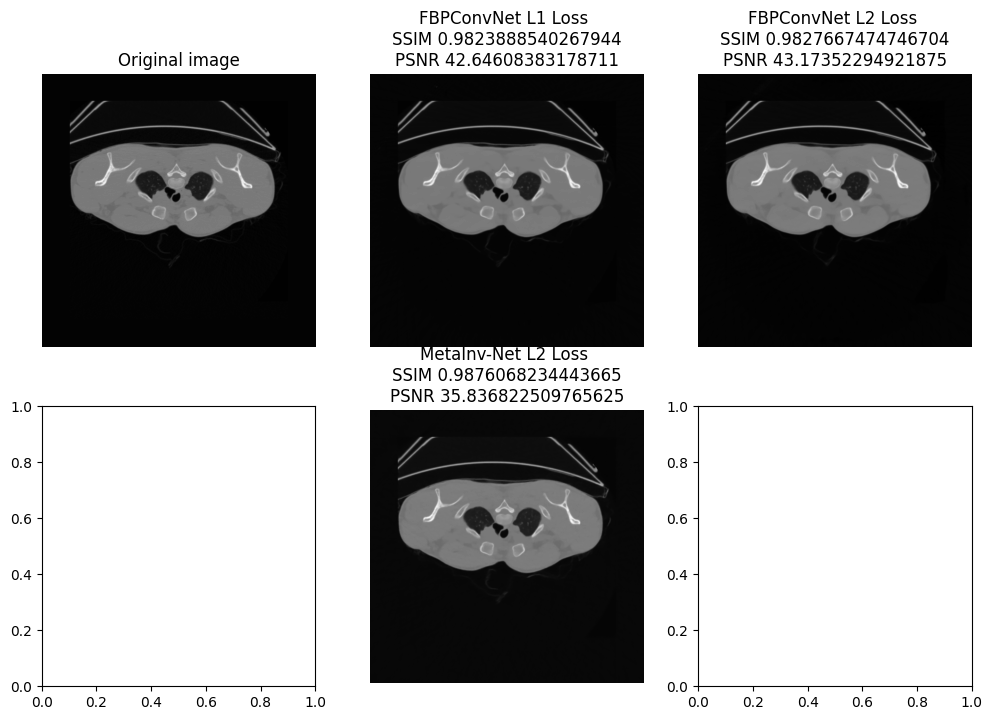

In [27]:
plot_images_non_noisy(25)

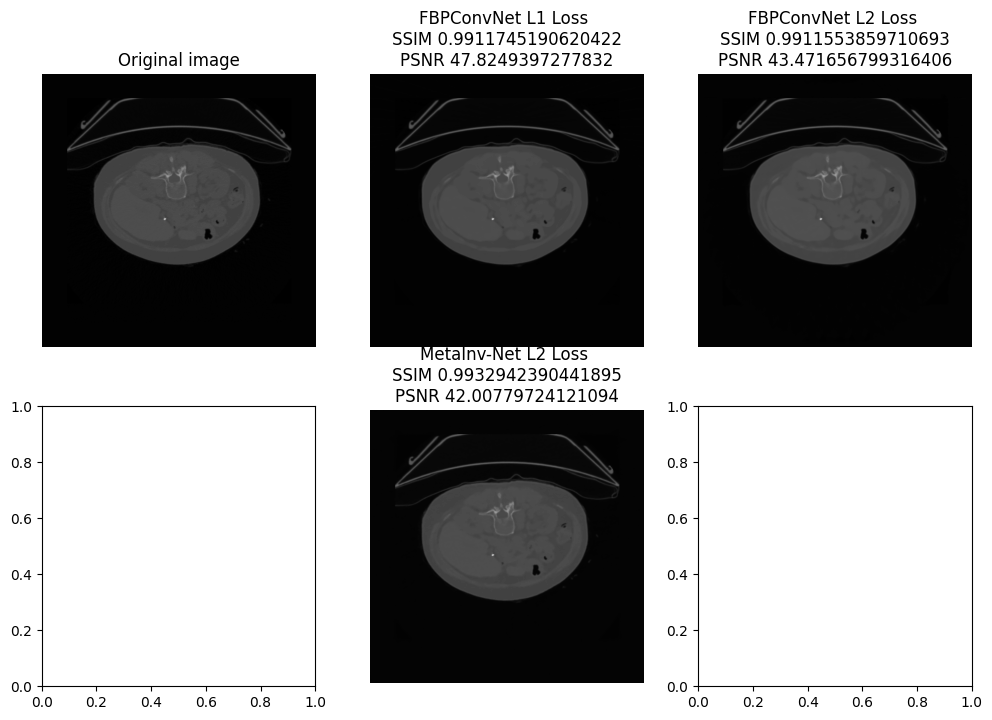

In [28]:
plot_images_non_noisy(55)

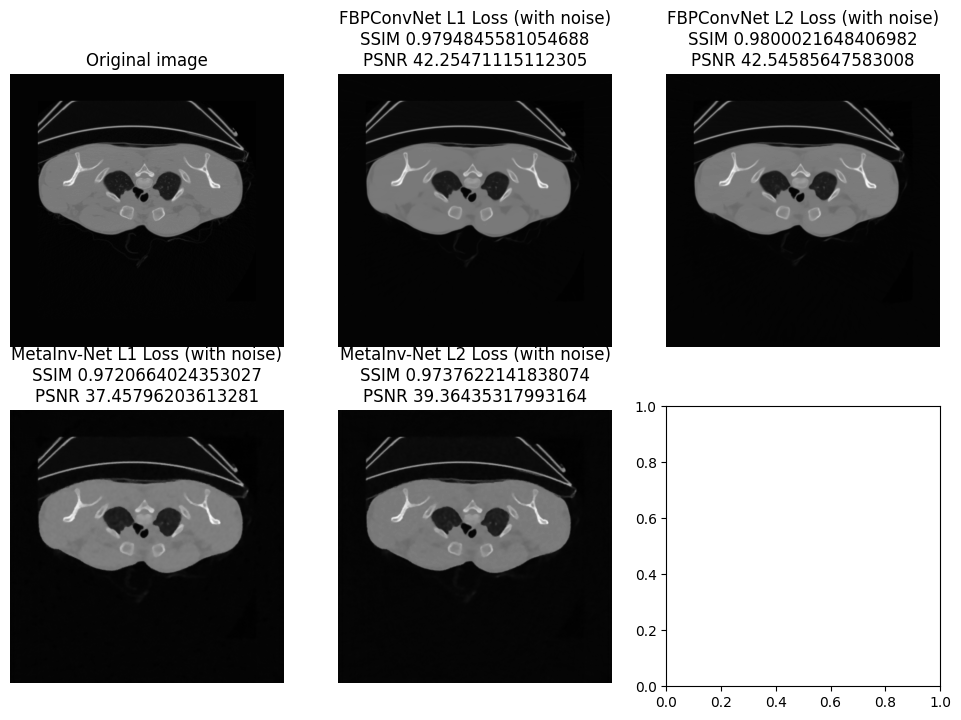

In [29]:
plot_images_noisy(25)

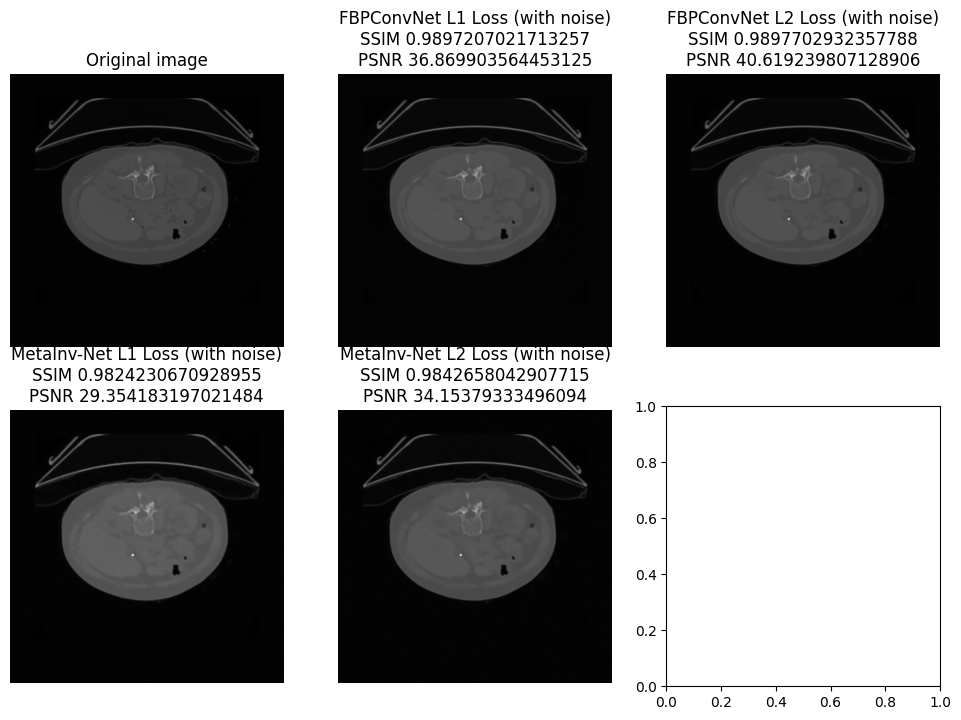

In [30]:
plot_images_noisy(55)

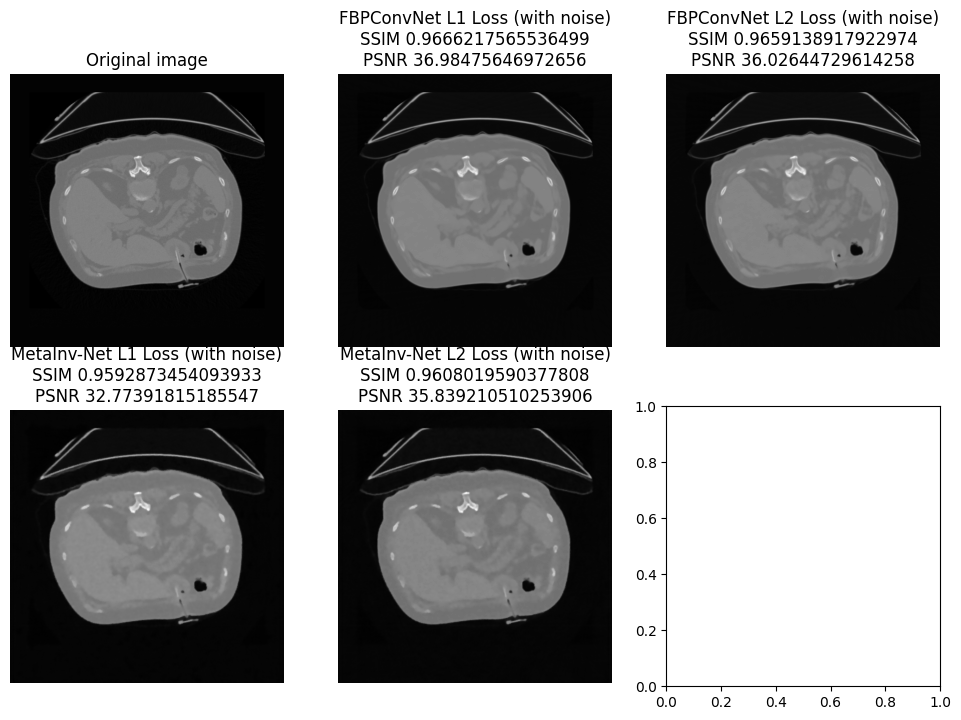

In [31]:
plot_images_noisy(75)